In [8]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax

In [9]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/


In [81]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)

In [112]:
paths = glob.glob(
    "panda_scans_v6/*.pkl"
)
all_data = pickle.load(open(paths[0], "rb"))
IDX = 1
data = all_data[IDX]

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


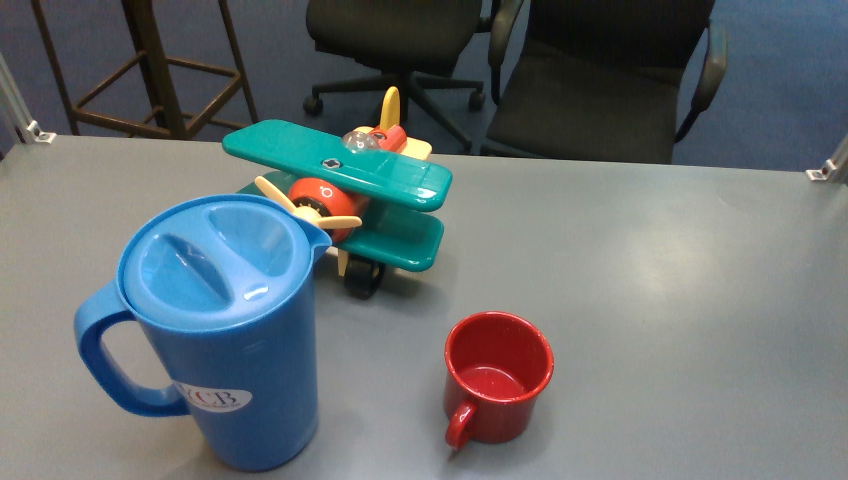

In [113]:
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
b.get_rgb_image(rgbd_original.rgb)

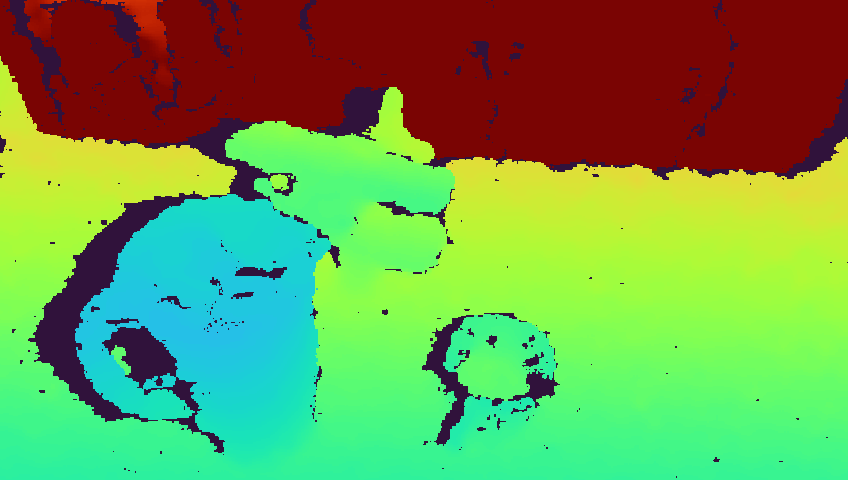

In [158]:
b.get_depth_image(rgbd_original.depth,max=1.5)

In [114]:
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [115]:
plane_pose, plane_dims = b.utils.find_plane_and_dims(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3), 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=1#0.1
)

In [132]:
plane_pose = plane_pose @ b.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)

In [133]:
b.clear()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", plane_pose)

In [134]:
mask = b.utils.scale(carvekit_get_foreground_mask(rgbd_original)*1.0, scaling_factor)

In [135]:
observed_depth = (rgbd_scaled_down.depth * mask) + (1.0 - mask)* rgbd_scaled_down.intrinsics.far

In [136]:
b.clear()
b.show_cloud("1", b.unproject_depth(observed_depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", plane_pose)

In [137]:
b.utils.ycb_loader.MODEL_NAMES[10]

'019_pitcher_base'

In [138]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
b.RENDERER.add_mesh_from_file("toy_plane.ply")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)
Centering mesh with translation [0.   0.   0.09]


In [139]:
for i in range(len(b.RENDERER.meshes)):
    b.show_trimesh(f"mesh_{i}", b.RENDERER.meshes[i])

In [176]:
grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


In [190]:
weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(3),
    "camera_pose": jnp.eye(4),
    "root_pose_0": plane_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": b.unproject_depth(observed_depth, rgbd_scaled_down.intrinsics),
    "variance": 0.0001,
    "outlier_prob": 0.0001,
    "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(1),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, 1.0)
)
b.viz_trace_meshcat(trace)
print(trace.get_score())

-10112.834


In [193]:
OBJECT_NUMBER = 1

In [194]:
address = f"contact_params_{OBJECT_NUMBER}"
trace = b.add_object_jit(trace, key, 2, 0, 2,3)
enumerators = b.make_enumerator([address])
b.viz_trace_meshcat(trace)

In [195]:
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[address]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    b.viz_trace_meshcat(trace)

In [ ]:
b.viz.scale_image(b.get_rgb_image(get_depth_image_alternate(b.get_rendered_image(trace)[...,2], 1.0)),5)

In [182]:
key = jax.random.split(key,1)[0]
new_object_idx = jax.random.choice(key,3)
trace_ = b.add_object_jit(trace, key, new_object_idx, 0, 2,3)
contact_param_grid = contact_param_deltas + trace[f"contact_params_1"]


In [180]:
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[f"contact_params_1"]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    b.viz_trace_meshcat(trace)

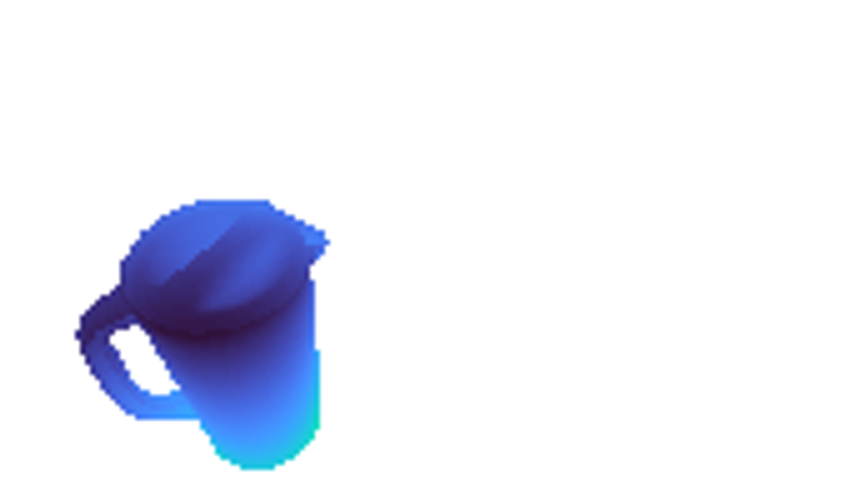

In [181]:
b.viz.scale_image(b.get_rgb_image(get_depth_image_alternate(b.get_rendered_image(trace)[...,2], 1.0)),5)

In [151]:
enumerators = b.make_enumerator([f"contact_params_2"])
trace = b.add_object_jit(trace, key, 1, 0, 2,3)
b.viz_trace_meshcat(trace)

In [152]:
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[f"contact_params_2"]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    b.viz_trace_meshcat(trace)

In [153]:
enumerators = b.make_enumerator([f"contact_params_3"])
trace = b.add_object_jit(trace, key, 0, 0, 2,3)
b.viz_trace_meshcat(trace)

In [154]:
for idx in range(len(contact_param_gridding_schedule)):
    contact_param_deltas = contact_param_gridding_schedule[idx]
    contact_param_grid = contact_param_deltas + trace[f"contact_params_3"]
    scores = enumerators[3](trace, key, contact_param_grid)
    i= jnp.unravel_index(scores.argmax(), scores.shape)
    trace = enumerators[0](
        trace, key,
        contact_param_grid[i]
    )
    b.viz_trace_meshcat(trace)

In [165]:
def get_depth_image_alternate(depth, maxval=None):
    far = jnp.max(depth)
    minval = jnp.min(depth[depth > jnp.min(depth)])
    if maxval is None:
        maxval = jnp.max(depth[depth < jnp.max(depth)])
    depth = depth.at[depth >= far].set(jnp.nan)
    viz_img = np.array(b.get_depth_image(
       depth, min=minval,  max=maxval
    ))
    viz_img[viz_img.sum(-1) == 0,:] = 255.0
    return viz_img

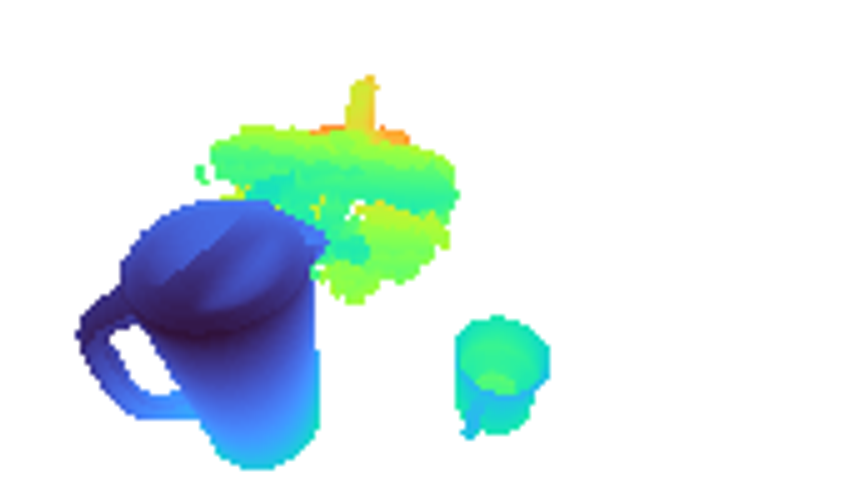

In [168]:
b.viz.scale_image(b.get_rgb_image(get_depth_image_alternate(b.get_rendered_image(trace)[...,2], 1.0)),5)

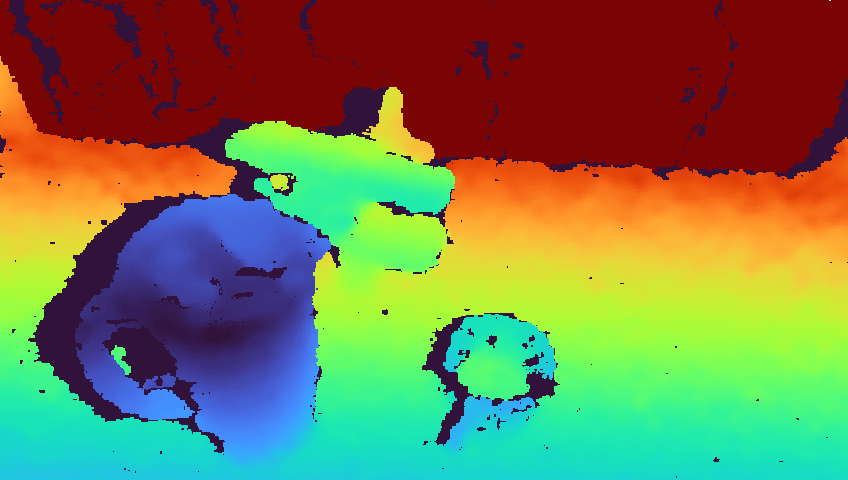

In [175]:
b.get_rgb_image(get_depth_image_alternate(jnp.array(rgbd_original.depth),1.0))